# Unemployment and Labor Markets over the Business Cycle

We will take a look at the data on unemployment and functioning of labor markets in the United States

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

In [2]:
from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

Below we are downloading two datasets. 

The first dataset, `fred`, contains monthly data on: 

- whether in a given month the US economy was in a recession state (`1`) or not (`0`) - `USREC`
- number of people in labor force in thousands - `CLF16OV`
- number of unemployed people in thousands - `UNEMPLOY`
- unemployment rate in percent - `UNRATE`
- number of job openings (vacancies) in thousands - `JTSJOL`
- job vacancy rate - `JTSJOR`

The second dataset, `hours`, contains quarterly data on:

- real GDP in billions of 2009 dollars - `GDPC1`
- total hours worked in the nonfarm business sector (index) - `HOANBS`
- average hours worked per employee in the nonfarm business sector (index) - `PRS85006023`
- number of employees in the nonfarm business sector (index) - `PRS85006013`

In [3]:
start = '1945-01'
end   = '2030-01'

In [4]:
# Get FRED data
fred = DataReader(['USREC', 'CLF16OV', 'UNEMPLOY', 'UNRATE', 'JTSJOL', 'JTSJOR'], 
                   'fred', start=start, end=end)

hours = DataReader(['GDPC1', 'HOANBS', 'PRS85006023', 'PRS85006013'], 
                    'fred', start=start, end=end)

Separate trend and cyclical components of GDP, hours and employment

In [5]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(100*np.log(hours[['GDPC1','HOANBS','PRS85006023','PRS85006013']]).dropna())
cf_cycle, cf_trend = sm.tsa.filters.cffilter(100*np.log(hours[['GDPC1','HOANBS','PRS85006023','PRS85006013']]).dropna())

Compare cyclical components of total hours worked vs its components: hours per employee and number of employees

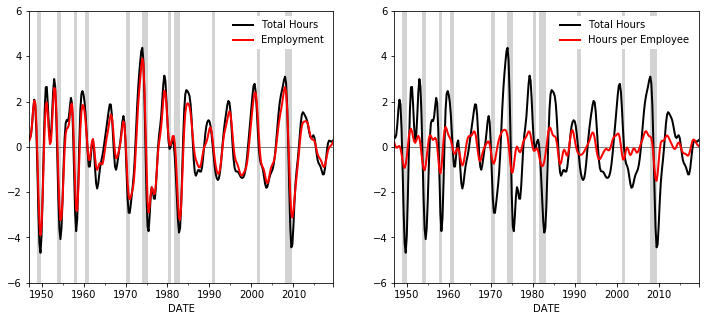

In [6]:
hp_cycle.columns = ['Output','Total Hours','Hours per Employee','Employment']
cf_cycle.columns = ['Output','Total Hours','Hours per Employee','Employment']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

cf_cycle[['Total Hours','Employment']].to_period('D').plot(ax=ax1, style=['k-','r-'], lw=2)

ylim = ax1.get_ylim()

ax1.hlines(0, cf_cycle.index[0], cf_cycle.index[-1], linewidth=0.5)
ax1.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax1.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

cf_cycle[['Total Hours','Hours per Employee']].to_period('D').plot(ax=ax2, style=['k-','r-'], lw=2)

ylim = ax2.get_ylim()

ax2.hlines(0, cf_cycle.index[0], cf_cycle.index[-1], linewidth=0.5)
ax2.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax2.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

# plt.savefig('Hours_CF.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

Calculate the variance-covariance matrix of total hours worked and its components

In [7]:
hp_cycle[['Total Hours','Employment','Hours per Employee']].cov()

,Total Hours,Employment,Hours per Employee
Total Hours,3.473058,2.822246,0.650821
Employment,2.822246,2.418658,0.403578
Hours per Employee,0.650821,0.403578,0.247262


## Constructing the vacancy rate time series

The statistics on job openings (vacancies) from the `JOLTS` program are available only starting from December 2000. However, there are data on `Help Wanted Index`, which were gathered by private companies. Thanks to the work of Regis Barnichon, we can use them.

In [8]:
dta = fred.copy()
dta.tail()

,USREC,CLF16OV,UNEMPLOY,UNRATE,JTSJOL,JTSJOR
DATE,,,,,,
2019-07-01,0,163351.0,6063.0,3.7,7174.0,4.5
2019-08-01,0,163922.0,6044.0,3.7,7301.0,4.6
2019-09-01,0,164039.0,5769.0,3.5,7024.0,4.4
2019-10-01,0,164364.0,5855.0,3.6,NaN,NaN
2019-11-01,0,164404.0,5811.0,3.5,NaN,NaN


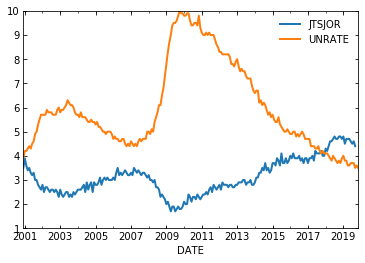

In [26]:
dta[['JTSJOR','UNRATE']]['2000-12':].plot(lw=2)
plt.legend(frameon=False)
plt.show()

Read in Regis Barnichon's Composite Help Wanted Index and join the two datasets

In [10]:
hwi = pd.read_csv('data/HWI_index_old.txt', delimiter='\t', skiprows=5)

# Manage dates
dates = []
for date in hwi['Date ']:
    dates.append(date[-2:]+'-01-'+date[0:4])

hwi.index = pd.to_datetime(dates)
hwi.index.rename('DATE', inplace=True)

# Cleanup
hwi = hwi.drop('Date ', 1)
hwi.columns = ['HWI']
hwi.tail()

,HWI
DATE,
2014-08-01,92.02
2014-09-01,87.76
2014-10-01,90.36
2014-11-01,91.35
2014-12-01,89.19


In [11]:
# Join datasets
df = dta.join(hwi)
df.tail()

,USREC,CLF16OV,UNEMPLOY,UNRATE,JTSJOL,JTSJOR,HWI
DATE,,,,,,,
2019-07-01,0,163351.0,6063.0,3.7,7174.0,4.5,NaN
2019-08-01,0,163922.0,6044.0,3.7,7301.0,4.6,NaN
2019-09-01,0,164039.0,5769.0,3.5,7024.0,4.4,NaN
2019-10-01,0,164364.0,5855.0,3.6,NaN,NaN,NaN
2019-11-01,0,164404.0,5811.0,3.5,NaN,NaN,NaN


Adjust the index to observed levels and splice the data from two sources

C:\Users\u157044\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


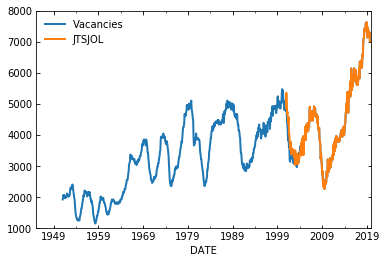

In [27]:
df['Vacancies'] = df['JTSJOL']['2014-01-01'] * df['HWI'] / df['HWI']['2014-01-01']
df['Vacancies']['2005-01-01':] = df['JTSJOL']['2005-01-01':]

df[['Vacancies','JTSJOL']].plot(lw=2)
plt.legend(frameon=False)
plt.show()

Construct time series for unemployment and vacancy rates

In [13]:
df['Unemployment rate'] = 100 * df['UNEMPLOY'] / df['CLF16OV']
df['Vacancy rate'] = 100 * df['Vacancies'] / df['CLF16OV']

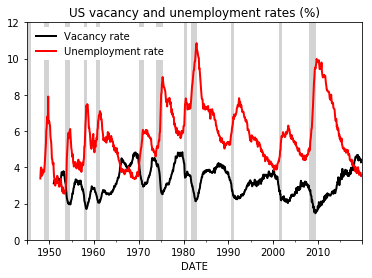

In [14]:
fig, ax = plt.subplots()

df['Vacancy rate'].to_period('D').plot(ax=ax, style='k', lw=2)
df['Unemployment rate'].to_period('D').plot(ax=ax, style='r', lw=2)

ylim = ax.get_ylim()

ax.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

l = ax.legend(loc='upper left')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

plt.title('US vacancy and unemployment rates (%)')
# plt.savefig('VU.pdf')
plt.show()

## Behavior of unemployment and vacancy rates in the United States

Below I plot the scatterplot of unemployment and vacancy rates, with colors reflecting different decades. 

The resulting negative relationship is known as the Beveridge curve

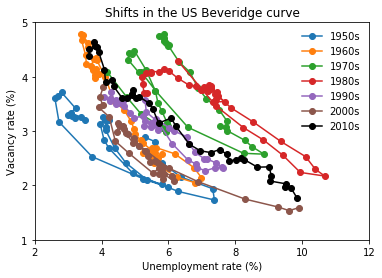

In [15]:
dfq = df.resample('QS').mean()

plt.plot(dfq['Unemployment rate']['1950-01-01':'1959-12-01'], 
         dfq['Vacancy rate']['1950-01-01':'1959-12-01'], 'o-', label='1950s')
plt.plot(dfq['Unemployment rate']['1960-01-01':'1969-12-01'], 
         dfq['Vacancy rate']['1960-01-01':'1969-12-01'], 'o-', label='1960s')
plt.plot(dfq['Unemployment rate']['1970-01-01':'1979-12-01'], 
         dfq['Vacancy rate']['1970-01-01':'1979-12-01'], 'o-', label='1970s')
plt.plot(dfq['Unemployment rate']['1980-01-01':'1989-12-01'], 
         dfq['Vacancy rate']['1980-01-01':'1989-12-01'], 'o-', label='1980s')
plt.plot(dfq['Unemployment rate']['1990-01-01':'1999-12-01'], 
         dfq['Vacancy rate']['1990-01-01':'1999-12-01'], 'o-', label='1990s')
plt.plot(dfq['Unemployment rate']['2000-01-01':'2009-12-01'], 
         dfq['Vacancy rate']['2000-01-01':'2009-12-01'], 'o-', label='2000s')
plt.plot(dfq['Unemployment rate']['2010-01-01':'2019-12-01'], 
         dfq['Vacancy rate']['2010-01-01':'2019-12-01'], 'ko-', label='2010s')

plt.legend(frameon=False)
plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')

plt.title('Shifts in the US Beveridge curve')
# plt.savefig('BC.pdf')
plt.show()

Separate trend from cycle to eliminate structural shifts to the Beveridge curve, note the adjustment of filtering options to monthly frequency

In [16]:
hp_cycle_uv, hp_trend_uv = sm.tsa.filters.hpfilter(100*np.log(df[['Vacancy rate','Unemployment rate']]).dropna(), 
                                             lamb=1600*3**4)

cf_cycle_uv, cf_trend_uv = sm.tsa.filters.cffilter(100*np.log(df[['Vacancy rate','Unemployment rate']]).dropna(), 
                                            low=1.5*12, high=8*12)

Plot cyclical components of unemployment and vacancy rates vs cyclical component of output

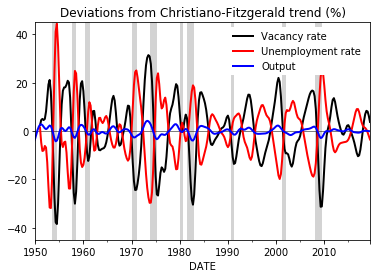

In [17]:
fig, ax = plt.subplots()

cf_cycle_uv.resample('QS').mean().to_period('D').plot(ax=ax, style=['k','r'], lw=2)
cf_cycle['Output'].plot(ax=ax, style=['b'], lw=2)

ax.set_ylim(-45, 45)
ylim = ax.get_ylim()

ax.hlines(0, hours.index[0], hours.index[-1], linewidth=0.5)

ax.fill_between(fred.index, ylim[0], ylim[1], fred['USREC'], facecolor='lightgrey', edgecolor='lightgrey')

ax.set_xlim('1950-01', hours.index[-1])

l = ax.legend(loc='upper right')
l.get_frame().set_linewidth(0)
l.get_frame().set_alpha(1)

plt.title('Deviations from Christiano-Fitzgerald trend (%)')
# plt.savefig('VU_CF.pdf')
plt.show()

Run a (very simplified) linear regression on cyclical components of unemployment and vacancy rates, the slope is very close to -1

-0.9768316135407601
2.8094364142215055e-11


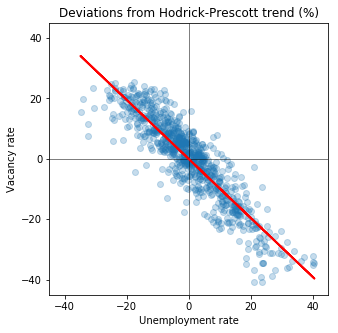

In [18]:
x = hp_cycle_uv['Unemployment rate']
y = hp_cycle_uv['Vacancy rate']

slope, intercept = np.polyfit(x, y, 1)

print(slope)
print(intercept)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(x, y, alpha=0.25) #facecolor='none', edgecolor='C0'
plt.plot(x, intercept + slope*x, 'r-', lw=2)

plt.xlim(-45, 45)
plt.ylim(-45, 45)

plt.hlines(0, -45, 45, linewidth=0.5)
plt.vlines(0, -45, 45, linewidth=0.5)

plt.title('Deviations from Hodrick-Prescott trend (%)')
plt.xlabel('Unemployment rate')
plt.ylabel('Vacancy rate')

# plt.savefig('BC_HP.pdf')

plt.show()

Generate the 'estimated' Beveridge curve without structural shifts

5.734405366795375 3.1892095895167833


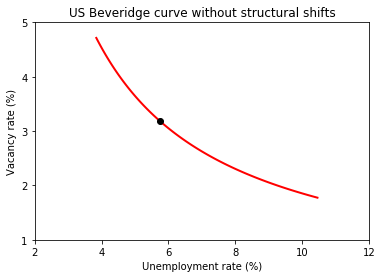

In [19]:
u = np.mean(dfq['Unemployment rate'])
v = np.mean(dfq['Vacancy rate'])

print(u, v)

scale = np.linspace(-40, 60, 101)

plt.plot(u*np.exp(scale/100), v*np.exp(intercept+slope*scale/100), 'r', lw=2)

plt.plot(u, v, 'ko')

plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

# plt.hlines(v, 2, u, linestyle='--', lw=1)
# plt.vlines(u, 1, v, linestyle='--', lw=1)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')
plt.title('US Beveridge curve without structural shifts')

# plt.savefig('BC_est.pdf')

plt.show()

5.734405366795375 3.1892095895167833


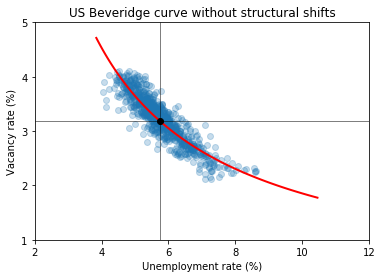

In [20]:
u = np.mean(dfq['Unemployment rate'])
v = np.mean(dfq['Vacancy rate'])

print(u, v)

scale = np.linspace(-40, 60, 101)

plt.plot(u*np.exp(scale/100), v*np.exp(intercept+slope*scale/100), 'r', lw=2)
plt.scatter(u*np.exp(x/100), v*np.exp(y/100), alpha=0.25) #, marker='.'

plt.plot(u, v, 'ko')

plt.xlim(2, 12)
plt.ylim(1, 5)
plt.yticks(np.arange(1, 6))

plt.hlines(v, 2, 12, linewidth=0.5)
plt.vlines(u, 1, 5, linewidth=0.5)

plt.xlabel('Unemployment rate (%)')
plt.ylabel('Vacancy rate (%)')
plt.title('US Beveridge curve without structural shifts')

# plt.savefig('BC_est_2.pdf')

plt.show()

In [1]:
from Dynare import *

In [25]:
var = 'mpn w n u v theta m q J'
varexo = 'e'

# Shimer (2005, AER)
# param_values = {'s':0.033, 'chi':0.45, 'eta':0.28, 'kappa':0.2098, 
#                 sy.symbols('beta'):0.99, sy.symbols('gamma'):0.28, 
#                 'b':0.4, 'rho':0.97, 'sigma':0.007}

# Mortensen & Nagypal (2007)
param_values = {'s':0.033, 'chi':0.45, 'eta':0.54, 'kappa':0.2098, 
                sy.symbols('beta'):0.99, sy.symbols('gamma'):0.928, 
                'b':0.965, 'rho':0.97}

model = ('-log(mpn) + rho*log(mpn(-1)) + e',
         '-w + gama*b + (1-gama)*(mpn + kappa*theta)',
         '-J + mpn - w + betta*(1-s)*J(+1)',
         '-kappa/q + betta * J(+1)',
         '-u + 1 - n',
         '-n + (1-s)*n(-1) + m(-1)',
         '-q + chi * theta^(eta-1)',
         '-m + chi * v^eta * u^(1-eta)',
         '-theta + v / u')

initval = (1, 1, 0.94, 0.06, 0.06, 1, 0.03, 0.5, 0.5)

In [26]:
Shimer = Dynare(var, varexo, param_values, model, initval)

Shimer.system

⎡  e_{t} + ρ⋅log(mpn_{t-1}) - log(mpn_{t})   ⎤
⎢                                            ⎥
⎢ b⋅γ - w_{t} + (-γ + 1)⋅(κ⋅θ_{t} + mpn_{t}) ⎥
⎢                                            ⎥
⎢J_{t+1}⋅β⋅(-s + 1) - J_{t} + mpn_{t} - w_{t}⎥
⎢                                            ⎥
⎢                           κ                ⎥
⎢             J_{t+1}⋅β - ─────              ⎥
⎢                         q_{t}              ⎥
⎢                                            ⎥
⎢             -n_{t} - u_{t} + 1             ⎥
⎢                                            ⎥
⎢     m_{t-1} + n_{t-1}⋅(-s + 1) - n_{t}     ⎥
⎢                                            ⎥
⎢                   η - 1                    ⎥
⎢            χ⋅θ_{t}      - q_{t}            ⎥
⎢                                            ⎥
⎢               -η + 1      η                ⎥
⎢        χ⋅u_{t}      ⋅v_{t}  - m_{t}        ⎥
⎢                                            ⎥
⎢                        v_{t}               ⎥
⎢            


STEADY-STATE RESULTS

mpn 	1.0000
w 	0.9810
n 	0.9275
u 	0.0725
v 	0.0645
theta 	0.8896
m 	0.0306
q 	0.4749
J 	0.4463

POLICY AND TRANSITION FUNCTIONS

		mpn	w	n	u	v	theta	m	q	J
Constant	1.0000	0.9810	0.9275	0.0725	0.0645	0.8896	0.0306	0.4749	0.4463
mpn(-1) 		0.9700	0.4936	-0.0000	0.0000	2.0325	28.0524	0.5212	-6.8883	6.6734
n(-1) 		0.0000	0.0000	0.9670	-0.9670	-0.8602	0.0000	-0.4085	0.0000	0.0000
m(-1) 		0.0000	0.0000	1.0000	-1.0000	-0.8896	0.0000	-0.4225	0.0000	0.0000
e     		1.0000	0.5089	0.0000	-0.0000	2.0954	28.9200	0.5373	-7.1013	6.8798



	Impulse response functions to e


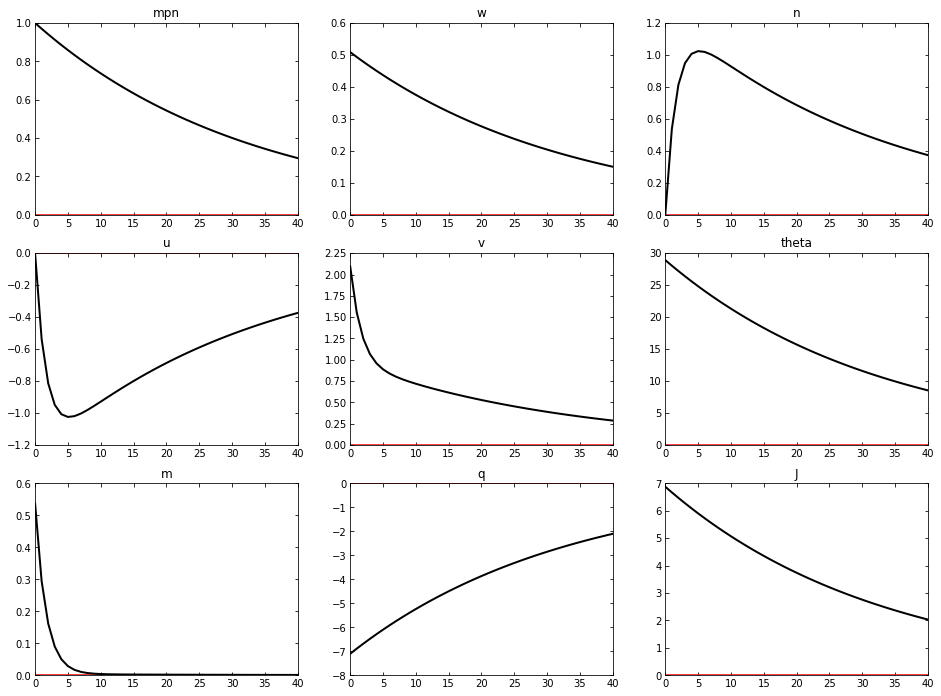

In [28]:
Shimer.steady()

Shimer.stoch_simul(irf=40)

In [92]:
series = Shimer.stoch_simul(irf=0, shocks_stderr=[0.004], periods=1000)


POLICY AND TRANSITION FUNCTIONS

		mpn	w	n	u	v	theta	m	q	J
Constant	1.0000	0.9810	0.9275	0.0725	0.0645	0.8896	0.0306	0.4749	0.4463
mpn(-1) 		0.9700	0.4936	-0.0000	0.0000	2.0325	28.0524	0.5212	-6.8883	6.6734
n(-1) 		0.0000	0.0000	0.9670	-0.9670	-0.8602	0.0000	-0.4085	0.0000	0.0000
m(-1) 		0.0000	0.0000	1.0000	-1.0000	-0.8896	0.0000	-0.4225	0.0000	0.0000
e     		1.0000	0.5089	0.0000	-0.0000	2.0954	28.9200	0.5373	-7.1013	6.8798


In [93]:
import pandas as pd

uu = 100 * np.log( (0.0725 + series[3][1:])/0.0725 )
vv = 100 * np.log( (0.0645 + series[4][1:])/0.0645 )

d = {'Unemployment':uu, 'Vacancies':vv}

sim = pd.DataFrame(data=d)

-1.1522811335250995
-12.192143075019798


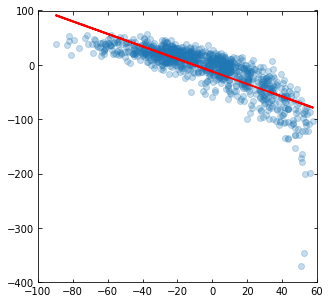

In [94]:
x = uu
y = vv

slope, intercept = np.polyfit(x, y, 1)

print(slope)
print(intercept)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(x, y, alpha=0.25) #facecolor='none', edgecolor='C0'
plt.plot(x, intercept + slope*x, 'r-', lw=2)

plt.show()

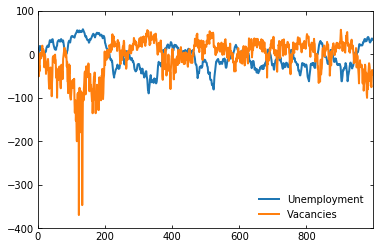

In [95]:
sim.plot(lw=2)
plt.show()

In [99]:
sim_c, sim_t = sm.tsa.filters.hpfilter(sim, lamb=1600)

-0.39393807487080185
4.727665405983585e-13


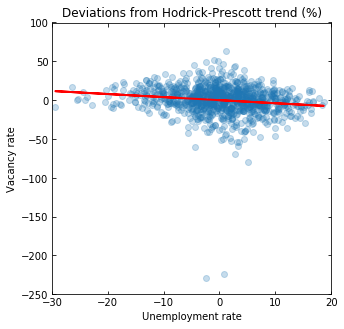

In [105]:
x = sim_c['Unemployment']
y = sim_c['Vacancies']

slope, intercept = np.polyfit(x, y, 1)

print(slope)
print(intercept)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(x, y, alpha=0.25) #facecolor='none', edgecolor='C0'
plt.plot(x, intercept + slope*x, 'r-', lw=2)

# plt.xlim(-45, 45)
# plt.ylim(-45, 45)

# plt.hlines(0, -45, 45, linewidth=0.5)
# plt.vlines(0, -45, 45, linewidth=0.5)

plt.title('Deviations from Hodrick-Prescott trend (%)')
plt.xlabel('Unemployment rate')
plt.ylabel('Vacancy rate')

plt.show()

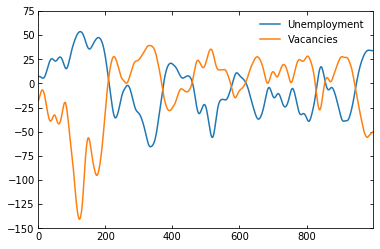

In [101]:
sim_t.plot()

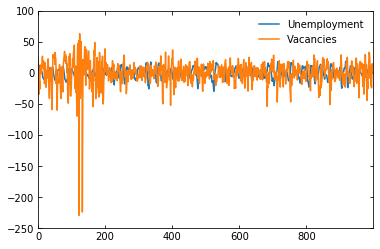

In [102]:
sim_c.plot()